# Reconstructing precipitation

This notebook shows how to reconstruct a variable that is not `tas`, e.g. precipitation or `pr`.

In [1]:
%load_ext autoreload
%autoreload 2

import cfr
print(cfr.__version__)

2024.1.26


## Load the PAGES2k database

Here we pick some TRW data for illustration purposes.

Slicing ProxyRecord: 100%|██████████| 19/19 [00:00<00:00, 2789.55it/s]


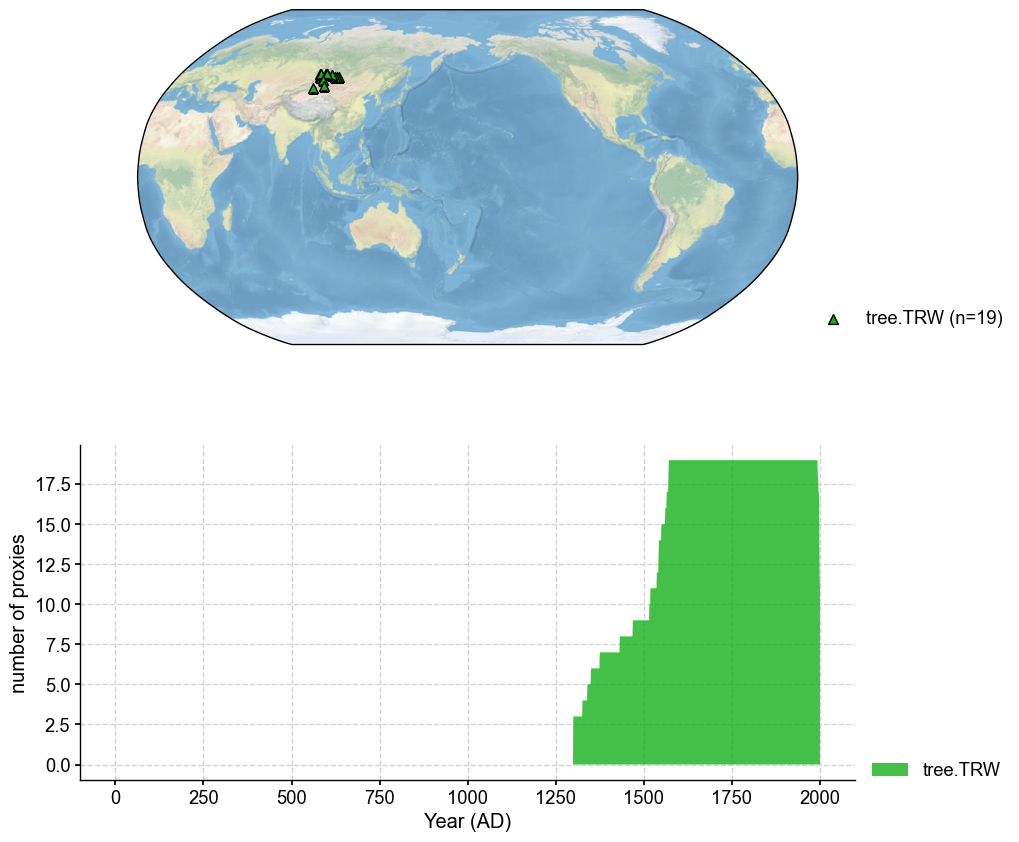

In [2]:
job = cfr.ReconJob()
job.load_proxydb('PAGES2kv2')
job.filter_proxydb(by='ptype', keys=['tree.TRW'])
job.filter_proxydb(by='loc-square', keys=[40, 50, 80, 100])
job.slice_proxydb(timespan=[1300, 2000])
fig, ax = job.proxydb.plot(plot_count=True)

## Load the gridded climate data

### Load the model prior

In [3]:
job.load_clim(
    tag='prior',
    path_dict={
        'pr': 'iCESM_past1000historical/pr',
    },
    anom_period=(1951, 1980),
)

>>> The target file seems existed at: ./data/pr_sfc_Amon_iCESM_past1000historical_085001-200512.nc . Loading from it instead of downloading ...


### Load the instrumental observations

In [8]:
job.load_clim(
    tag='obs',
    path_dict={
        'pr': 'GPCCv2020',
    },
    rename_dict={'pr': 'precip'},
    anom_period=(1982, 2020),
)

>>> The target file seems existed at: ./data/precip.monitor.mon.total.1x1.v2020.nc . Loading from it instead of downloading ...


## Proxy system modeling

### Calibrating the proxy system models

Here is the key part that is different from the case reconstructing `tas` only.
We need to specify `ptype_clim_dict`, which tells `cfr` which variable is the required climate variable for each proxy type.
**This is a new feature added in v2024.1.26.**

Note that a side effect is that by default it sets `tas` for every proxy type, so if the `Bilinear` PSM is applied, one need to explicitly set, for example, `ptype_clim_dict = {'tree.TRW': ['tas', 'pr']}`.

In [11]:
ptype_psm_dict = {
    'tree.TRW': 'Linear',
}

ptype_season_dict = {
    'tree.TRW': [3, 4, 5, 6, 7, 8],
}

ptype_clim_dict = {
    'tree.TRW': ['pr'],
}

job.calib_psms(
    ptype_psm_dict=ptype_psm_dict,
    ptype_season_dict=ptype_season_dict,
    ptype_clim_dict=ptype_clim_dict,
    calib_period=(1982, 2020),
    nobs_lb=15,
    verbose=True,
)

>>> job.configs["ptype_psm_dict"] = {'tree.TRW': 'Linear'}
>>> job.configs["ptype_season_dict"] = {'tree.TRW': [3, 4, 5, 6, 7, 8]}
>>> job.configs["ptype_clim_dict"] = {'tree.TRW': ['pr']}
>>> job.configs["psm_calib_period"] = (1982, 2020)


Calibrating the PSMs:  21%|██        | 4/19 [00:00<00:00, 37.09it/s]

The number of overlapped data points is 14 < 15. Skipping ...


Calibrating the PSMs: 100%|██████████| 19/19 [00:00<00:00, 84.28it/s]

The number of overlapped data points is 12 < 15. Skipping ...
>>> PSM for Asi_159 failed to be calibrated.
>>> PSM for Asi_074 failed to be calibrated.
>>> 17 records tagged "calibrated" with ProxyRecord.psm created


### Forwarding the proxy system models

In [13]:
job.forward_psms()

Forwarding the PSMs: 100%|██████████| 17/17 [00:01<00:00, 12.02it/s]


## Annualizing, regridding, and cropping the prior field

In [14]:
job.annualize_clim(tag='prior', verbose=True)
job.regrid_clim(tag='prior', nlat=42, nlon=63, verbose=True)
job.crop_clim(tag='prior', lat_min=30, lat_max=60, lon_min=70, lon_max=110, verbose=True)

>>> job.configs["prior_annualize_months"] = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
>>> Processing pr ...
>>> job.prior updated
>>> job.configs["prior_regrid_nlat"] = 42
>>> job.configs["prior_regrid_nlon"] = 63
>>> Processing pr ...
>>> job.configs["prior_lat_min"] = 30
>>> job.configs["prior_lat_max"] = 60
>>> job.configs["prior_lon_min"] = 70
>>> job.configs["prior_lon_max"] = 110
>>> Processing pr ...


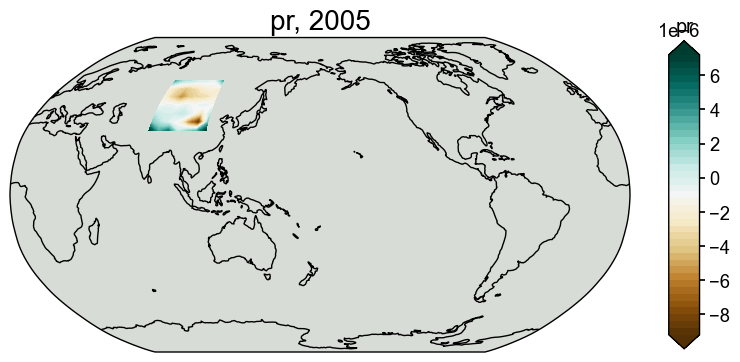

In [16]:
fig, ax = job.prior['pr'][-1].plot()

## Run the DA solver

In [36]:
job.run_da_mc(
    save_dirpath='./recons/lmr-recon-pr',
    recon_seeds=list(range(1, 11)),
    recon_vars=['pr'],
    verbose=True,
)

>>> job.configs["recon_vars"] = ['pr']
>>> job.configs["recon_seeds"] = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
>>> job.configs["save_dirpath"] = ./recons/lmr-recon-pr
>>> seed: 1 | max: 10


KF updating: 100%|██████████| 2001/2001 [00:00<00:00, 2464.11it/s] 


>>> Reconstructed fields saved to: ./recons/lmr-recon-pr/job_r01_recon.nc
>>> seed: 2 | max: 10


KF updating: 100%|██████████| 2001/2001 [00:01<00:00, 1971.25it/s] 


>>> Reconstructed fields saved to: ./recons/lmr-recon-pr/job_r02_recon.nc
>>> seed: 3 | max: 10


KF updating: 100%|██████████| 2001/2001 [00:00<00:00, 2012.68it/s] 


>>> Reconstructed fields saved to: ./recons/lmr-recon-pr/job_r03_recon.nc
>>> seed: 4 | max: 10


KF updating: 100%|██████████| 2001/2001 [00:01<00:00, 1929.56it/s] 


>>> Reconstructed fields saved to: ./recons/lmr-recon-pr/job_r04_recon.nc
>>> seed: 5 | max: 10


KF updating: 100%|██████████| 2001/2001 [00:01<00:00, 1832.87it/s]


>>> Reconstructed fields saved to: ./recons/lmr-recon-pr/job_r05_recon.nc
>>> seed: 6 | max: 10


KF updating: 100%|██████████| 2001/2001 [00:01<00:00, 1876.63it/s] 


>>> Reconstructed fields saved to: ./recons/lmr-recon-pr/job_r06_recon.nc
>>> seed: 7 | max: 10


KF updating: 100%|██████████| 2001/2001 [00:01<00:00, 1718.45it/s] 


>>> Reconstructed fields saved to: ./recons/lmr-recon-pr/job_r07_recon.nc
>>> seed: 8 | max: 10


KF updating: 100%|██████████| 2001/2001 [00:01<00:00, 1704.40it/s]


>>> Reconstructed fields saved to: ./recons/lmr-recon-pr/job_r08_recon.nc
>>> seed: 9 | max: 10


KF updating: 100%|██████████| 2001/2001 [00:01<00:00, 1811.84it/s] 


>>> Reconstructed fields saved to: ./recons/lmr-recon-pr/job_r09_recon.nc
>>> seed: 10 | max: 10


KF updating: 100%|██████████| 2001/2001 [00:01<00:00, 1847.93it/s] 


>>> Reconstructed fields saved to: ./recons/lmr-recon-pr/job_r10_recon.nc
>>> DONE! Total time spent: 0.22 mins.


## Validate the reconstruction

In [37]:
res = cfr.ReconRes('./recons/lmr-recon-pr')
res.load(['pr'], verbose=True)

>>> ReconRes.recons["pr"] created
>>> ReconRes.da["pr"] created


### Load the validation target

In [38]:
target = cfr.ClimateField().fetch('GPCCv2020', vn='precip').rename('pr').get_anom((1982, 2020)).annualize()

>>> The target file seems existed at: ./data/precip.monitor.mon.total.1x1.v2020.nc . Loading from it instead of downloading ...


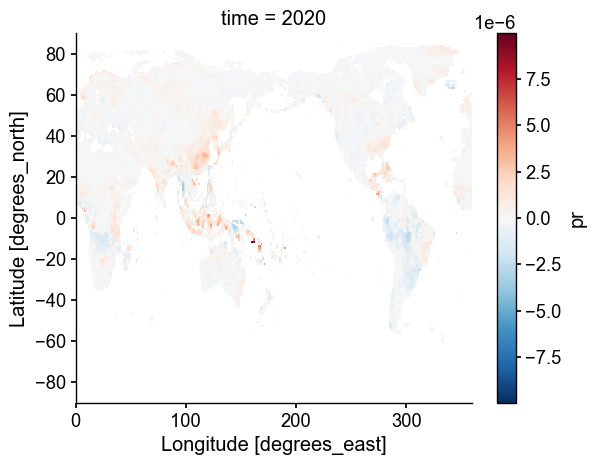

In [39]:
# we need to convert the unit to be precipitation rate
target.da /= 3600*24*365.25
target.da[-4].plot()

### Field validation

This is just an example.
It's not surprising that the skill is not high.

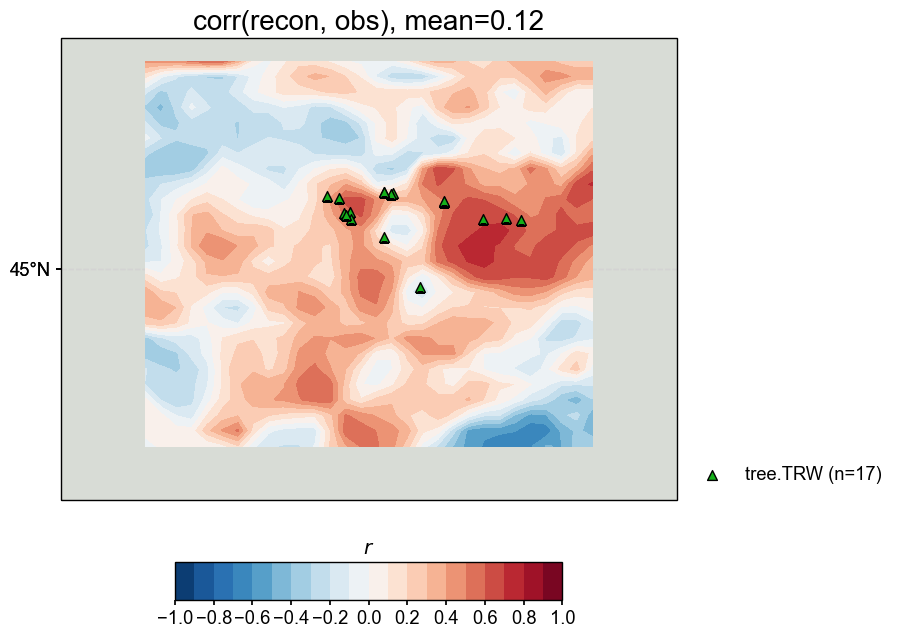

In [40]:
stat = 'corr'

valid_fd = res.recons['pr'].compare(
    target, stat=stat,
    timespan=(1982, 2000),
)
valid_fd.plot_kwargs.update({'cbar_orientation': 'horizontal', 'cbar_pad': 0.1})

fig, ax = valid_fd.plot(
    title=f'{stat}(recon, obs), mean={valid_fd.geo_mean().value[0,0]:.2f}',
    projection='PlateCarree',
    latlon_range=(30, 60, 70, 110),
    plot_cbar=True, plot_proxydb=True, proxydb=job.proxydb.filter(by='tag', keys=['calibrated']),
    plot_proxydb_lgd=True, proxydb_lgd_kws={'loc': 'lower left', 'bbox_to_anchor': (1, 0)},
)